In [1]:
import os
import re
import json
from typing import Dict, List, Any, Optional
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import load_workbook
import glob
from pathlib import Path

In [2]:
CHECKLIST_XLSX = r"D:\vscode_projects\hoff_data\DKS\checklists\Звонки для ИИ.xlsx"
CHECKLIST_SHEET = "Обращение (уровень КС)"
TRANSCRIPTS_DIR = r"D:\vscode_projects\Hoff\dks_2\whisper-diarization\transcripts\obrashenie_ks"
OUTPUT_CSV = "df_for_ui3.csv"

# Посмотрим на разметку чеклистов

In [3]:
# Убираем веса параметров, чтобы все оценки могли быть 0,1 или 2

WEIGHTS: Dict[str, int] = {
    'Приветствие': 1,
    'Завершение разговора': 1,
    'Холд': 1,
    'Точное определение цели обращения клиента (выяснение причины запроса)': 5,
    'Предоставление клиенту точной (корректной) информации по вопросу. / Выполнение алгоритма исходящего звонка': 9,
    'Ориентир по дальнейшим действиям клиента и компании.': 9,
    'Доброжелательность, эмпатия, вежливые слова': 3,
    'Работа с возражением и негативом клиента': 4,
    'Активное ведение диалога / слушания': 4,
    'Сверка данных с АХ12': 5,
    'Полнота и точность ввода данных': 8,
}

In [4]:
# Точечные фильтры для очистки данных
FILTERS: List[Dict[str, Any]] = [
    {
        "column": "Предоставление клиенту точной (корректной) информации по вопросу. / Выполнение алгоритма исходящего звонка",
        "op": "ne",
        "value": 15
    },
]

In [5]:
# Data Loading & Initial Filter

def load_raw_checklist(
    filepath: str,
    sheet_name: str,
    header_row: int = 2
) -> pd.DataFrame:
    wb = load_workbook(filepath, data_only=True)
    ws = wb[sheet_name]
    header = [cell.value for cell in ws[header_row]]
    rows = []
    for row in ws.iter_rows(min_row=header_row + 1):
        if ws.row_dimensions[row[0].row].hidden:
            continue
        rows.append([cell.value for cell in row])
    return pd.DataFrame(rows, columns=header)

In [6]:
def apply_filters(df: pd.DataFrame, filters: List[Dict[str, Any]]) -> pd.DataFrame:
    df = df.copy()
    for f in filters:
        col, op, val = f["column"], f["op"], f["value"]
        if op == "ne":
            df = df[df[col] != val]
        elif op == "eq":
            df = df[df[col] == val]
        elif op == "gt":
            df = df[df[col] > val]
        elif op == "lt":
            df = df[df[col] < val]
        elif op == "ge":
            df = df[df[col] >= val]
        elif op == "le":
            df = df[df[col] <= val]
        else:
            raise ValueError(f"Unsupported op: {op}")
    return df.reset_index(drop=True)

In [7]:
# Normalization

def normalize_columns(df: pd.DataFrame, weights: Dict[str, int]) -> pd.DataFrame:
    df = df.copy()
    for col, w in weights.items():
        if col in df.columns:
            df[col] = (df[col] / w).astype(int)
    return df

In [8]:
# Transcript File Matching

def get_valid_ids(transcripts_dir: str) -> set:
    return {
        os.path.splitext(f)[0]
        for f in os.listdir(transcripts_dir)
        if f.endswith(".txt")
    }

def filter_by_transcripts(df: pd.DataFrame, transcripts_dir: str) -> pd.DataFrame:
    valid = get_valid_ids(transcripts_dir)
    return df[df['ID Вызова'].isin(valid)].reset_index(drop=True)

In [9]:
df_raw = load_raw_checklist(CHECKLIST_XLSX, CHECKLIST_SHEET)
df_filtered = apply_filters(df_raw, FILTERS)
df_norm = normalize_columns(df_filtered, WEIGHTS)
df_ready = filter_by_transcripts(df_norm, TRANSCRIPTS_DIR)

d:\vscode_projects\itmo_sys_design\.venv\Lib\site-packages\openpyxl\packaging\relationship.py:118: UserWarning: xl/pivotCache/_rels/pivotCacheDefinition1.xml.rels contains invalid dependency definitions
  warn(msg)


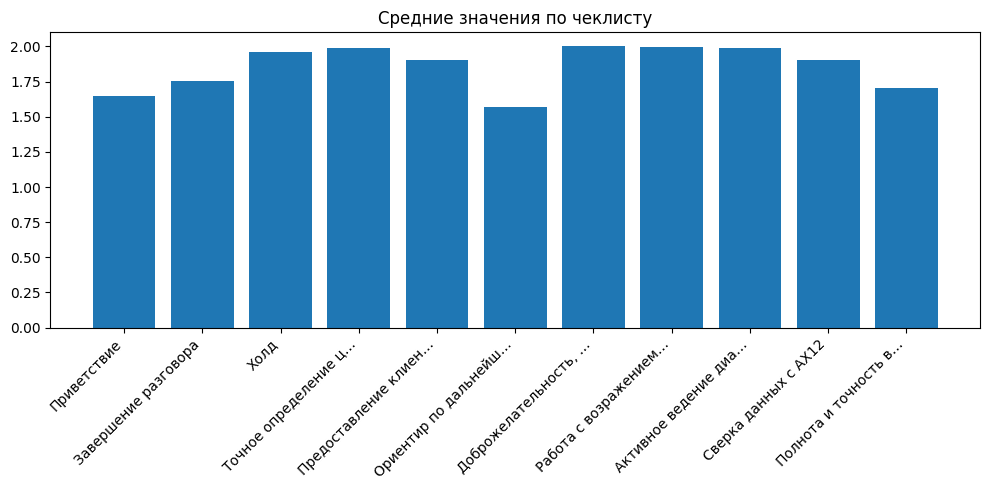

In [10]:
cols = list(WEIGHTS.keys())
means = df_ready[cols].mean()
labels = [c[:20] + ("…" if len(c) > 20 else "") for c in cols]

plt.figure(figsize=(10, 5))
plt.title("Средние значения по чеклисту")
plt.bar(range(len(means)), means.values)
plt.xticks(range(len(means)), labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Теперь посмотрим на тексты транскрибации диалогов

In [11]:
TRANSCRIPTS_DIR = Path(TRANSCRIPTS_DIR)

files = sorted(TRANSCRIPTS_DIR.glob("**/*.txt"))
len(files)

181

In [12]:
def read_text(path: Path) -> str:
    return path.read_text(encoding="utf-8", errors="replace")

rows = []
for p in files:
    text = read_text(p)
    rows.append({
        "path": str(p),
        "file": p.name,
        "relpath": str(p.relative_to(TRANSCRIPTS_DIR)),
        "size_bytes": p.stat().st_size,
        "text_raw": text,
    })

df = pd.DataFrame(rows)
df.head()

,path,file,relpath,size_bytes,text_raw
0,D:\vscode_projects\Hoff\dks_2\whisper-diarizat...,00716000891741868331.txt,00716000891741868331.txt,2663,"﻿Оператор: Добрый день, [MASKED_PER]. Компани..."
1,D:\vscode_projects\Hoff\dks_2\whisper-diarizat...,00716000991737975711.txt,00716000991737975711.txt,6252,"﻿Оператор: Добрый день, компания [MASKED_PER],..."
2,D:\vscode_projects\Hoff\dks_2\whisper-diarizat...,00716002441742650221.txt,00716002441742650221.txt,5590,"﻿Оператор: Привет, компания [MASKED_PER], меня..."
3,D:\vscode_projects\Hoff\dks_2\whisper-diarizat...,00716002571737364449.txt,00716002571737364449.txt,1805,"﻿Оператор: Добрый день, компания [MASKED_ORG]...."
4,D:\vscode_projects\Hoff\dks_2\whisper-diarizat...,00716002631738765324.txt,00716002631738765324.txt,1969,﻿Оператор: Вечер. Компания «[MASKED_ORG]» из ...


In [13]:
_ws_re = re.compile(r"\s+")
_word_re = re.compile(r"[A-Za-zА-Яа-яЁё0-9]+(?:[-'][A-Za-zА-Яа-яЁё0-9]+)*")

def normalize_text(s: str) -> str:
    s = s.replace("\ufeff", "")  # BOM
    s = s.strip()
    s = _ws_re.sub(" ", s)
    return s

def tokenize_words(s: str):
    return _word_re.findall(s.lower())

df["text"] = df["text_raw"].map(normalize_text)

df["n_chars"] = df["text"].str.len()
df["words"] = df["text"].map(tokenize_words)
df["n_words"] = df["words"].map(len)

df[["file","n_chars","n_words"]].head()

,file,n_chars,n_words
0,00716000891741868331.txt,1479,227
1,00716000991737975711.txt,3472,558
2,00716002441742650221.txt,3131,499
3,00716002571737364449.txt,1042,160
4,00716002631738765324.txt,1104,170


Средняя длина (символы): 2019.3
Средняя длина (слова): 314.7


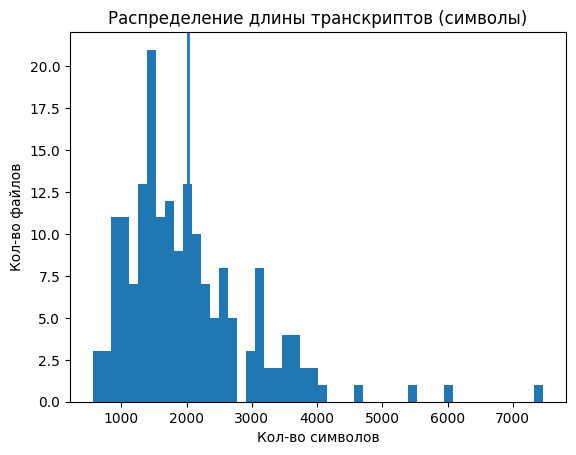

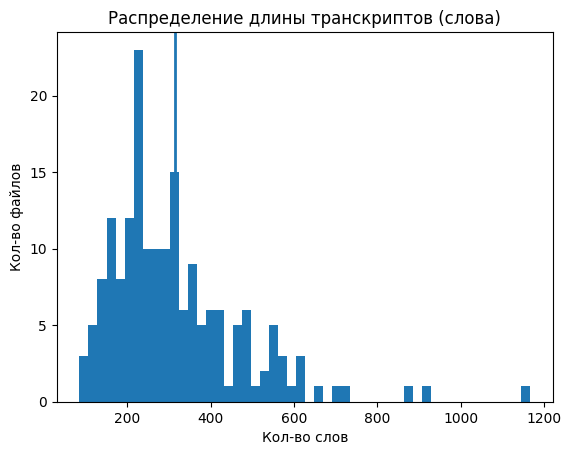

In [14]:
# средние
mean_chars = df["n_chars"].mean()
mean_words = df["n_words"].mean()

print(f"Средняя длина (символы): {mean_chars:.1f}")
print(f"Средняя длина (слова): {mean_words:.1f}")

# гистограмма по символам
plt.figure()
plt.hist(df["n_chars"].dropna(), bins=50)
plt.axvline(mean_chars, linewidth=2)
plt.title("Распределение длины транскриптов (символы)")
plt.xlabel("Кол-во символов")
plt.ylabel("Кол-во файлов")
plt.show()

# гистограмма по словам
plt.figure()
plt.hist(df["n_words"].dropna(), bins=50)
plt.axvline(mean_words, linewidth=2)
plt.title("Распределение длины транскриптов (слова)")
plt.xlabel("Кол-во слов")
plt.ylabel("Кол-во файлов")
plt.show()